In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator

from sklearn.model_selection import train_test_split

In [2]:
path = '/Users/tristangarcia/desktop/Network Traffic Classification/data/'

train = pd.read_pickle(f"{path}train.pkl")
x_train, y_train, y2_train = train.drop(columns=['label','attack_cat']), train['label'], train['attack_cat']

test = pd.read_pickle(f'{path}test.pkl')
x_test, y_test, y2_test = test.drop(columns=['label','attack_cat']), test['label'], test['attack_cat']

In [3]:
cat_cols = ['proto','service','state']
bin_cols = ['is_ftp_login','is_sm_ips_ports']
num_cols = list(set(x_train.columns)-set(cat_cols)-set(bin_cols))

# Helper functions

In [4]:
def multi_corr(col1, target, df):
    '''
    Returns
    - correlation between a feature and target
    - correlation between log1p of a feature and target
    '''
    corr = df[col1].corr(target)
    log_corr = df[col1].apply(np.log1p).corr(target)
    diff = np.abs(log_corr) - np.abs(corr)
    
    print(f"Correlation : {corr}\nlog_Correlation: {log_corr}")
    print(f'Absolute difference: {diff}')
    return diff

In [5]:
def log1p_transform(log_cols, df):
    '''
    - log_cols is a list of columns that need to be log transformed from df
    - For each column, a new log transformed column is made
    - Original column removed
    '''
    for col in log_cols:
        new_col = 'log_' + col
        df[new_col] = df[col].apply(np.log1p)
        df = df.drop(columns=[col])
    return df

In [6]:
# cat_cols = ['proto','service','state']
def ohe_transform(df, transformer):
    '''
    - Performs one hot encoding on selected categorical variables on a df
    - Encoder must be made prior to running this function
    '''
    # Encoding
    transformed = transformer.transform(df)
    # Reformatting OHE column names
    transformer_names = transformer.get_feature_names_out()
    ohe_names = [name.split('__', 1)[-1] for name in transformer_names]
    # Converting back to dataframe
    transformed_df = pd.DataFrame(transformed.toarray(), columns=ohe_names)
    transformed_df.index = df.index
    # Joining OHE df with other numerical features
    df = pd.concat([df, transformed_df], axis=1)
    df = df.drop(columns=cat_cols)
    return df

# Standardisation

In [7]:
scaler = StandardScaler()
scaler = scaler.fit(x_train[num_cols])

In [8]:
x_train[num_cols] = scaler.transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

# Correlated Features

In [9]:
corr_matrix = x_train[num_cols].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

['sbytes', 'ct_src_ ltm', 'ct_dst_ltm', 'dbytes', 'dloss', 'ct_srv_dst', 'swin', 'ltime', 'ct_srv_src']


In [10]:
# Dropping variables
x_train = x_train.drop(columns=to_drop)
x_test = x_test.drop(columns=to_drop)
num_cols = [col for col in num_cols if col not in to_drop]

In [11]:
print(x_train.columns)

Index(['proto', 'state', 'dur', 'sttl', 'dttl', 'sloss', 'service', 'sload',
       'dload', 'spkts', 'dpkts', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports',
       'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'],
      dtype='object')


# Log Transformation

In [12]:
# Correlation of feature and log(feature) with label
log_cols = []
for col in num_cols:
    print("{:-^30}".format(col))
    diff = multi_corr(col1=col, target=y_train, df=x_train)
    if diff > 0.05:
        log_cols.append(f'{col}')
        
# Printing features that have had a significant difference in correlation
print('\nFeature with corr and log_corr greater than 0.05:')
print(log_cols)

------------stime-------------
Correlation : 0.017263315826805792
log_Correlation: -0.02040377711037151
Absolute difference: 0.0031404612835657167
-------ct_src_dport_ltm-------
Correlation : 0.2866636873498954
log_Correlation: 0.35974404870513965
Absolute difference: 0.07308036135524426
----------ct_ftp_cmd----------
Correlation : -0.037392952927228
log_Correlation: -0.03795926636313796
Absolute difference: 0.0005663134359099598
------------sloss-------------
Correlation : -0.029351404925141305
log_Correlation: -0.23794340888996904
Absolute difference: 0.20859200396482774
------------dpkts-------------
Correlation : -0.13273508740017767
log_Correlation: -0.25653604345794134
Absolute difference: 0.12380095605776367
-------------dur--------------
Correlation : 0.025330972329810134
log_Correlation: -0.004070191827830896
Absolute difference: -0.02126078050197924
------------dtcpb-------------
Correlation : -0.26149528344680156
log_Correlation: -0.30039561128430176
Absolute difference: 0.0

In [13]:
# Log transforming columns
x_train = log1p_transform(log_cols,x_train)
x_test = log1p_transform(log_cols,x_test)

In [14]:
x_train.columns

Index(['proto', 'state', 'dur', 'sttl', 'service', 'dwin', 'stcpb', 'dtcpb',
       'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'sintpkt',
       'dintpkt', 'is_sm_ips_ports', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_dst_src_ltm', 'log_ct_src_dport_ltm', 'log_sloss',
       'log_dpkts', 'log_spkts', 'log_dttl', 'log_sload', 'log_dload',
       'log_ct_dst_sport_ltm', 'log_smeansz', 'log_ct_state_ttl',
       'log_dmeansz', 'log_tcprtt', 'log_synack', 'log_ackdat'],
      dtype='object')

In [15]:
x_test.columns

Index(['proto', 'state', 'dur', 'sttl', 'service', 'dwin', 'stcpb', 'dtcpb',
       'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'sintpkt',
       'dintpkt', 'is_sm_ips_ports', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_dst_src_ltm', 'log_ct_src_dport_ltm', 'log_sloss',
       'log_dpkts', 'log_spkts', 'log_dttl', 'log_sload', 'log_dload',
       'log_ct_dst_sport_ltm', 'log_smeansz', 'log_ct_state_ttl',
       'log_dmeansz', 'log_tcprtt', 'log_synack', 'log_ackdat'],
      dtype='object')

# One Hot Encoding

In [16]:
# Create encoder. handle_unknown ensures that unseen values in the test set are ignored
t = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), 
                                      ['proto','service','state']))
t.fit(x_train)

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['proto', 'service', 'state'])])

In [17]:
# ohe_transform is a helper function
x_train = ohe_transform(x_train,t)
x_test = ohe_transform(x_test,t)

In [18]:
x_train.head()

,dur,sttl,dwin,stcpb,dtcpb,trans_depth,res_bdy_len,sjit,djit,stime,...,state_FIN,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URN,state_no
243907,0.015180,1.939302,1.029420,1.691942,1.089912,-0.269146,-0.082915,0.597460,-0.267618,0.160393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191921,-0.157269,-0.581895,-0.971442,-0.756638,-0.756604,-0.269146,-0.082915,-0.083209,-0.267618,-0.367714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
834,-0.128723,-0.231415,-0.971442,-0.756638,-0.756604,-0.269146,-0.082915,-0.080849,-0.256835,-1.719048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91993,0.159566,-0.581895,1.029420,0.049912,0.053045,3.237089,0.000798,0.430809,3.701843,-0.973767,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6540,-0.154096,-0.581895,1.029420,0.312168,0.319025,-0.269146,-0.082915,-0.083209,-0.259230,-1.651834,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
x_test.head()

,dur,sttl,dwin,stcpb,dtcpb,trans_depth,res_bdy_len,sjit,djit,stime,...,state_FIN,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URN,state_no
38528,-0.157542,1.939302,-0.971442,-0.756638,-0.756604,-0.269146,-0.082915,-0.083209,-0.267618,-1.290914,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409182,-0.152989,-0.581895,1.029420,2.160006,2.163994,-0.269146,-0.082915,-0.081691,-0.256105,1.452420,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93521,-0.157543,-0.254027,-0.971442,-0.756638,-0.756604,-0.269146,-0.082915,-0.083209,-0.267618,-0.963600,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200708,-0.157542,-0.254027,-0.971442,-0.756638,-0.756604,-0.269146,-0.082915,-0.083209,-0.267618,-0.319422,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362074,-0.145733,-0.581895,1.029420,0.778567,0.814146,-0.269146,-0.082915,-0.079132,-0.233883,1.157301,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# LabelEncoding

In [20]:
# LabelEncoder for the multiple Attack types
encoder = LabelEncoder()
encoder.fit(y2_train)

LabelEncoder()

In [21]:
# Label encoding attack_cat for train and test sets
y2_train = encoder.transform(y2_train)
y2_test = encoder.transform(y2_test)
# Converting to dataframes
y2_train = pd.DataFrame(y2_train, columns=['y2_train'])
y2_test = pd.DataFrame(y2_test, columns=['y2_test'])

In [22]:
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'analysis': 0, 'backdoor': 1, 'dos': 2, 'exploits': 3, 'fuzzers': 4, 'generic': 5, 'normal': 6, 'reconnaissance': 7, 'shellcode': 8, 'worms': 9}


# PCA

In [23]:
# Apply PCA
pca = PCA()
pca.fit(x_train)
explained_variances = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variances)

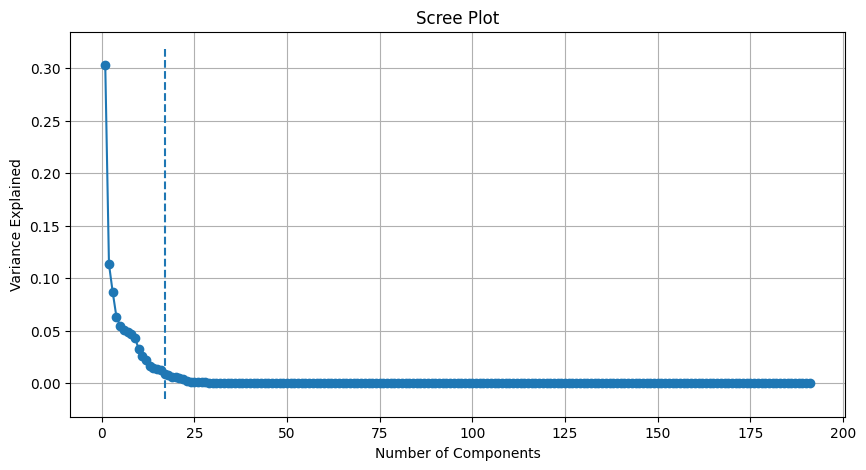

In [24]:
# Using Kneedle to find the elbow
kneedle = KneeLocator(range(1, len(explained_variances) + 1), explained_variances, curve='convex', direction='decreasing')

# Plot to verify the elbow point
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.vlines(kneedle.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.grid(True)
plt.show()

In [25]:
print("Elbow point component:", kneedle.elbow)

Elbow point component: 17


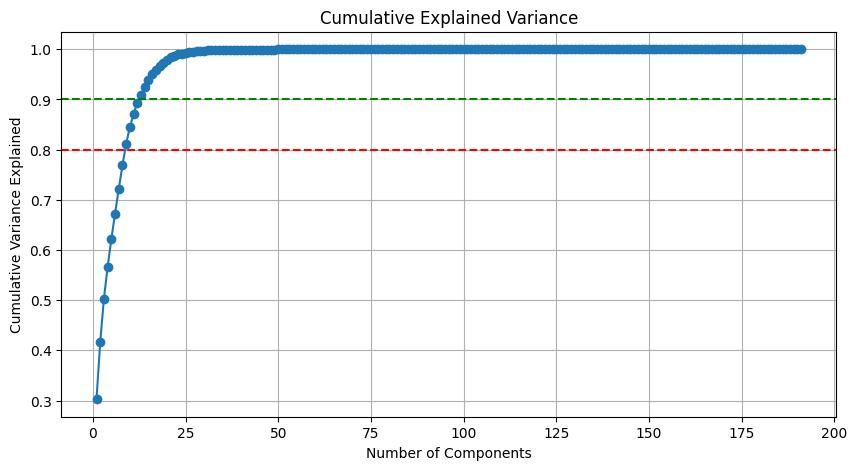

In [26]:
# Cumulative explained variance plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.axhline(y=0.9, color='g', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

In [27]:
components_80 = np.where(cumulative_variance >= 0.8)[0][0] + 1
components_90 = np.where(cumulative_variance >= 0.9)[0][0] + 1

print(f"Components to explain at least 80% of variance: {components_80}")
print(f"Components to explain at least 90% of variance: {components_90}")

Components to explain at least 80% of variance: 9
Components to explain at least 90% of variance: 13


We will use 17 principal components
- Elbow method suggests 17 PCs
- 90% explained cumulative variance suggests 13 PCs

In [28]:
# Using 19 PC's
pca_19 = PCA(n_components=19)

pca_train = pca_19.fit_transform(x_train)
pca_test = pca_19.transform(x_test)

In [29]:
# Converting to dataframe
pca_labels = [f'PC{i}' for i in range(1,20)]
pca_train = pd.DataFrame(pca_train, columns = pca_labels)
pca_test = pd.DataFrame(pca_test, columns = pca_labels)

In [30]:
pca_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,1.503771,-0.241097,0.290418,2.384572,-0.638977,1.820591,0.119462,0.088392,-0.076650,-0.443795,1.672480,0.057030,-0.404435,0.465557,1.021368,1.938068,-0.243354,1.440800,-0.017281
1,-0.699532,-0.590196,0.374695,-1.855894,-0.654100,0.604377,0.446387,-0.397399,0.287071,-0.129791,0.031365,0.101778,-0.031596,0.014084,0.597347,0.203588,0.009372,-0.243952,0.127289
2,-0.590685,-0.228542,0.187441,-0.838167,-0.691704,1.315731,0.143375,-1.779694,0.092971,-0.019276,0.442967,-0.027529,0.089226,0.002814,-0.273898,0.851680,-0.119330,-0.134375,1.322804
3,3.187906,4.506196,-1.247347,-1.182779,-1.250984,-0.334662,-0.053194,-0.911553,-0.626587,0.532279,-1.022543,-0.096945,0.544190,-0.007945,-0.662205,0.255922,0.213947,-0.078678,-0.196467
4,2.261338,-1.350138,0.088328,-0.061738,0.181000,-0.082998,-0.793700,-1.521423,0.221992,-0.162731,-1.035931,0.204840,-0.693099,-0.023801,-0.422005,-0.036825,0.163212,0.098031,0.110581


In [31]:
pca_test.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,-1.636911,-0.048155,0.264451,0.696563,-0.398225,2.199135,0.270294,-1.483493,-0.159348,-0.149142,-0.342142,-0.052445,0.646289,-0.017096,-0.683376,-1.193193,-0.044475,0.563224,-0.122127
1,3.308498,-1.399964,-0.108434,1.087578,0.592028,-0.499332,-0.768707,1.621523,-0.103500,-0.215549,-0.363752,0.191440,-0.177773,0.008586,1.160505,-0.510501,0.075874,0.453942,0.283691
2,-3.476791,0.406116,-0.534681,-0.086615,0.378690,-1.982337,-0.673454,-0.858211,0.051614,0.229911,0.333983,-0.065166,-0.334694,0.002372,-0.074457,0.462845,-0.007844,0.149454,-0.157681
3,-2.606740,0.110079,-0.205782,-0.592808,0.028316,-0.978693,-0.189575,-0.273695,0.070479,0.126861,0.335078,-0.083093,-0.019416,0.001868,-0.039115,-0.047621,0.013779,0.015417,0.046372
4,2.276110,-1.097438,0.058742,0.293676,0.255079,-0.107494,-0.356121,1.251052,0.043754,-0.126904,-0.395631,0.089031,-0.159072,-0.031172,-0.033604,-0.028216,0.002244,0.078856,-0.217992


# Validation Split

In [32]:
# Getting indices for validation and test sets
indices = np.arange(len(y2_test))
indices_validate, indices_test = train_test_split(indices, stratify=y2_test, 
                                                  test_size=0.5, random_state=123)

# Applying indices to form validation and new test sets
x_validate = x_test.iloc[indices_validate]
x_test = x_test.iloc[indices_test]
pca_validate = pca_test.iloc[indices_validate]
pca_test = pca_test.iloc[indices_test]
y_validate = y_test.iloc[indices_validate]
y_test = y_test.iloc[indices_test]
y2_validate = y2_test.iloc[indices_validate]
y2_test = y2_test.iloc[indices_test]

# Outputting Data

In [33]:
path += 'final/'

# Training sets
x_train.to_pickle(f'{path}xtrain.pkl')
pca_train.to_pickle(f'{path}pcatrain.pkl')
y_train.to_pickle(f'{path}ytrain.pkl')
y2_train.to_pickle(f'{path}y2train.pkl')

# Validation sets
x_validate.to_pickle(f'{path}xvalidate.pkl')
pca_validate.to_pickle(f'{path}pcavalidate.pkl')
y_validate.to_pickle(f'{path}yvalidate.pkl')
y2_validate.to_pickle(f'{path}y2validate.pkl')

# Test sets
x_test.to_pickle(f'{path}xtest.pkl')
pca_test.to_pickle(f'{path}pcatest.pkl')
y_test.to_pickle(f'{path}ytest.pkl')
y2_test.to_pickle(f'{path}y2test.pkl')